# 单车预测器
### 利用tf2

## 1.导入模块

In [1]:
'''
env:  python3.7   tensorflow2.1
'''

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## 2.设置显卡
貌似只有jupyter要写控制显卡内存

In [15]:
import os
os.environ["CUDA_VISIBLE_EDVICES"] = '0' #指定代号为0的那块GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3 #使得程序最多只能占用指定GPU的30%，这个语句主要用来限制程序占有GPU的比例。
config.gpu_options.allow_growth = True #程序能够按照它的需求去申请内存。
sess = tf.compat.v1.Session(config = config)

## 3.导入数据

In [16]:
data_path = './bike-sharing-dataset/hour.csv'
rides = pd.read_csv(data_path)

## 4.数据预处理

In [17]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
    
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

quant_feature = ['cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_feature:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

test_data = data[-21 * 24:]
train_data = data[:-21 * 24]

target_fields = ['cnt', 'casual', 'registered']

features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

## 5.模型搭建

In [18]:
input_size=features.shape[1]
hidden_size=10
output_size=1
batch_size = 128

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_size, input_dim=input_size),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(output_size),
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.01)  # alias: 
# choose loss function and optimizing method
model.compile(loss='mse', optimizer=sgd)

## 6.训练并保存数据

In [19]:
#model.fit(X, Y, epochs=1000, batch_size=128)

#model.save('my_model.h5')

## 7.调用训练好的模型

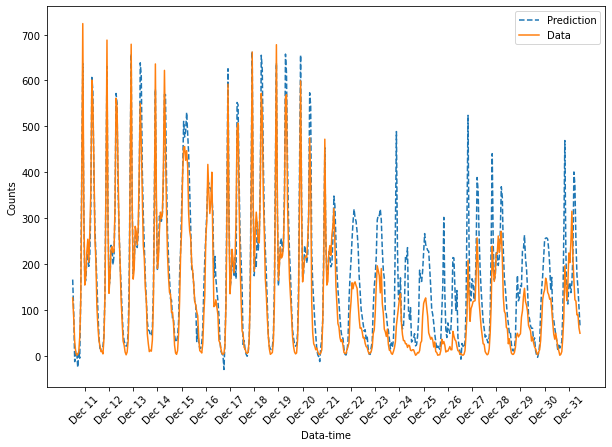

In [20]:
model1 = tf.keras.models.load_model('my_model.h5')
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt']  #读取测试集的cnt数值
targets = targets.values.reshape([len(targets), 1])  #将数据转换成合适的tensor形式
targets = targets.astype(float)  #保证数据为实数

#用神经网络进行预测
predict = model1.predict(test_features.values)

fig,ax=plt.subplots(figsize=(10,7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle='--')
ax.plot(targets * std + mean, label='Data', linestyle='-')
ax.legend()
ax.set_xlabel('Data-time')
ax.set_ylabel('Counts')
dates=pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates=dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_=ax.set_xticklabels(dates[12::24],rotation=45)